In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [1]:
import os
import shutil

# Define source and destination directories.
src_dir = '/data/zucksliu/ahonjaya_tempura_migrated/ahonjaya/logs/AI-READI-Results/OCTA/Averaged_Results'
dst_dir = '/projects/chimera/zucksliu/AI-READI-2.0/dataset/retinal_octa/Averaged_results_test'

# List of subfolder names to copy.
folders_to_copy = ['1122']

# Create destination directory if it doesn't exist.
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

# Loop over the specified folder names.
for folder_name in folders_to_copy:
    src_path = os.path.join(src_dir, folder_name)
    dst_path = os.path.join(dst_dir, folder_name)

    if os.path.exists(src_path):
        # Copy the entire folder recursively.
        shutil.copytree(src_path, dst_path)
        print(f"Copied folder {folder_name} to {dst_dir}")
    else:
        print(f"Folder {folder_name} does not exist in {src_dir}")

Copied folder 1122 to /projects/chimera/zucksliu/AI-READI-2.0/dataset/retinal_octa/Averaged_results_test


In [9]:
root = '/projects/chimera/zucksliu/AI-READI-2.0/dataset/'
octa_dir = root + 'retinal_octa/'
octa_manifest_tsv = octa_dir + 'manifest.tsv'

full_manifest = pd.read_csv(octa_manifest_tsv, sep='\t')

if 'participant_id' not in full_manifest.columns:
    raise ValueError("The manifest must contain a 'participant_id' column for splitting.")

unique_ids = full_manifest['participant_id'].unique()
np.random.seed(42)
np.random.shuffle(unique_ids)

split_idx = int(0.9 * len(unique_ids))
selected_ids = unique_ids
manifest = full_manifest[full_manifest['participant_id'].isin(selected_ids)].reset_index(drop=True)

print(selected_ids)

[7323 1315 1071 ... 1122 7395 7209]


In [12]:
class_names = ['Background', 'Capillary', 'Artery', 'Vein', 'FAZ']
probabilities_by_class = {cls: [] for cls in class_names}

# Group the manifest by participant_id.
grouped = manifest.groupby('participant_id')
i=0
base_dir = '/data/zucksliu/ahonjaya_tempura_migrated/ahonjaya/logs/AI-READI-Results/Registration_Merging_Results_v2/OCTA/'
fail = set()
success = set()
fail_image = set()
all_p = set()
success_image = set()
success_patient = set()
fail_patient = set()
patients = set()
# Loop over each selected participant.
for p_id in tqdm(selected_ids, desc='Processing participants'):
    group_df = grouped.get_group(p_id)
    for idx, row in group_df.iterrows():
        # Build the folder structure based on the new directory organization.
        # The first folder is named "{p_id}_{laterality}"
        folder1 = osp.join(base_dir, f"{p_id}_{row['laterality']}")
        # The second folder is named "{manufacturers_model_name}_{anatomic_region}"
        folder2 = osp.join(folder1, f"{row['manufacturers_model_name']}_{row['anatomic_region']}")
        # Within that folder, go into the "npy" subfolder.
        npy_folder = osp.join(folder2, "npy")
        # The file we want to load is "softmax.npy".
        softmax_path = osp.join(npy_folder, "softmax.npy")
        if os.path.exists(softmax_path):
            data_label = np.load(softmax_path)
            # Assume data_label is a numpy array of shape (C, H, W)
            # Compute predicted labels and then get probabilities per class.
            predicted = np.argmax(data_label, axis=0)
            for i, cls in enumerate(class_names):
                mask = (predicted == i)
                class_probs = data_label[i][mask]
                probabilities_by_class[cls].extend(class_probs.tolist())
                # print(data_label[i])
            success_image.add(f"{row['associated_enface_1_file_path']}")
            success_patient.add(f"{row['participant_id']}")
            # success.add(f"{row['participant_id']}_{row['laterality']}")
        else:
            # fail.add(f"{row['participant_id']}_{row['laterality']}")
            fail_image.add(f"{row['associated_enface_1_file_path']}")
            # fail_patient.add(f"{row['participant_id']}")
        all_p.add(f"{row['associated_enface_1_file_path']}")
        patients.add(f"{row['participant_id']}")

print(f"Success patient: {len(success_patient)}")
print(f"Success image: {len(success_image)}")
print(f"Fail_image: {len(fail_image)}")
print(f"Total image: {len(all_p)}")
print(f"patient: {len(patients)}")
# print(patients)

# success_manifest = manifest[(manifest['associated_enface_1_file_path']).isin(success_image)].copy()
# success_manifest = success_manifest.drop_duplicates(subset=['participant_id', 'manufacturers_model_name', 'anatomic_region', 'laterality'], keep='last')
# success_manifest.to_csv('/projects/chimera/zucksliu/AI-READI-2.0/dataset/retinal_octa/success_manifest_train_w_no_dups.tsv', sep='\t', index=False)
# print("Success manifest saved to 'success_manifest.tsv'")


Processing participants: 100%|██████████| 1060/1060 [00:06<00:00, 166.40it/s]

Success patient: 868
Success image: 7303
Fail_image: 3193
Total image: 10496
patient: 1060


[0.02945686 0.86489886 0.86859894 ... 0.75394696 0.03530205 0.85010427]
[0.89690572 0.89354295 0.90112537 ... 0.91842127 0.92655158 0.93069714]
[0.90199047 0.90714902 0.900832   ... 0.92139894 0.92733878 0.91416281]
[0.92856765 0.9272688  0.92598963 ... 0.92735982 0.91931075 0.939816  ]
[0.88372326 0.89618975 0.87015986 ... 0.93117833 0.92817801 0.92428201]


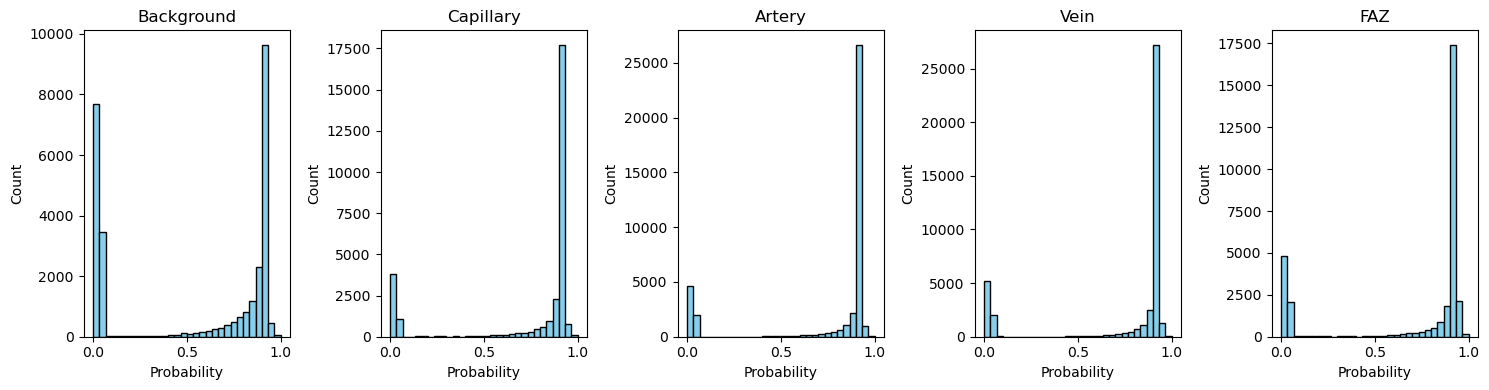

In [58]:
plt.figure(figsize=(15, 4))
for i, cls in enumerate(class_names):
    plt.subplot(1, 5, i+1)
    probs = np.array(probabilities_by_class[cls])
    print(probs)
    plt.hist(probs, bins=30, range=(0, 1), color='skyblue', edgecolor='black')
    plt.title(cls)
    plt.xlabel('Probability')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [59]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from tqdm import tqdm

# Set the root directories.
# The original manifest is assumed to be in the "retinal_octa" folder under the dataset root.
root = '/projects/chimera/zucksliu/AI-READI-2.0/dataset/'
octa_dir = osp.join(root, 'retinal_octa')
manifest_path = osp.join(octa_dir, 'manifest.tsv')

# Load the manifest.
manifest = pd.read_csv(manifest_path, sep='\t')

if 'participant_id' not in manifest.columns:
    raise ValueError("The manifest must contain a 'participant_id' column.")

# Set the base directory for the new folder structure.
# In this new organization, each row's corresponding softmax file is expected to be at:
# {base_dir}/{participant_id}_{laterality}/{manufacturers_model_name}_{anatomic_region}/npy/softmax.npy
base_dir = '/data/zucksliu/ahonjaya_tempura_migrated/ahonjaya/logs/AI-READI-Results/Registration_Merging_Results_v2/OCTA/'

def softmax_file_exists(row):
    """
    Given a row from the manifest, build the expected path for softmax.npy and return True if it exists.
    """
    # Remove any extra whitespace by stripping the string fields.
    participant_id = str(row['participant_id']).strip()
    laterality = str(row['laterality']).strip()
    manufacturers_model_name = str(row['manufacturers_model_name']).strip()
    anatomic_region = str(row['anatomic_region']).strip()

    folder1 = osp.join(base_dir, f"{participant_id}_{laterality}")
    folder2 = osp.join(folder1, f"{manufacturers_model_name}_{anatomic_region}")
    npy_folder = osp.join(folder2, "npy")
    softmax_path = osp.join(npy_folder, "softmax.npy")
    return os.path.exists(softmax_path)

# Apply the file existence check to each row.
# This will create a new column 'exists' that is True if the softmax file is found.
manifest['exists'] = manifest.apply(softmax_file_exists, axis=1)

# Filter the manifest to only rows where the softmax file exists.
success_manifest = manifest[manifest['exists']].copy()

# Drop the helper 'exists' column so that the output has exactly the same columns as the original manifest.
success_manifest.drop(columns=['exists'], inplace=True)

# Save the filtered manifest to a TSV file.
output_path = osp.join(octa_dir, "manifest_all_success.tsv")
success_manifest.to_csv(output_path, sep='\t', index=False)

print(f"Saved manifest for all successful rows to: {output_path}")

Saved manifest for all successful rows to: /projects/chimera/zucksliu/AI-READI-2.0/dataset/retinal_octa/manifest_all_success.tsv
